# Unsupervised Anomaly Detection using Vector Embeddings from LLM on DNS logs
1/22/2025, Dave Sisk, https://github.com/davidcsisk, https://www.linkedin.com/in/davesisk-doctordatabase/

This is a continuation of the prior research. In this notebook, we are leveraging the <u>Isolation Forest</u> algorithm to perform unsupervised training of an anomaly detection model, using text <u>vector embeddings</u> as the input. In this working example, we will use one of the common sentence-transformer Large Language Models off-the-shelf with no fine-tuning.

In [1]:
### Uncomment and run the line below if this is the first time executing this notebook. Package installs in requirements.txt.
#! python -m venv venv
#! powershell venv\Scripts\Activate.ps1
#! pip install pandas 
#! pip install matplotlib
#! pip install scikit-learn
#! pip install sentence-transformers


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

c:\Users\Dave Sisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
# We'll use DNS test data that we split from the full data set in the prior fine-tuning process. 
df = pd.read_csv('dns-log_test-data.csv')

In [4]:
# Preprocess a single row by concatenating all columns 
def preprocess_dns_row(row):
    # Combine all column values in the row into a single lowercase string
    concatenated = ' '.join(map(str, row))  # Combine all columns into a single string
    return concatenated.lower()  # Convert the string to lowercase

# Apply the function row-wise and assign the result to the 'document' column
df['document'] = df.apply(preprocess_dns_row, axis=1)

In [5]:
# Load the embedding model so we can use it to easily populate the dataframe
vector_embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2') # Base vector embedding model

# Use a lambda function to encode the text in each row and apply it to a new column
# This will take around 5 mins to run...
df['embedding'] = df['document'].apply(lambda text:vector_embedder.encode(text))
df.sample(3)

c:\Users\Dave Sisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,protocol,resolved_address,class,query_type,response,rejected,document,embedding
23039,udp,186.21.168.192.in-addr.arpa,C_INTERNET,PTR,NXDOMAIN,F,udp 186.21.168.192.in-addr.arpa c_internet ptr...,"[-0.023653125, 0.028026279, 0.009689131, -0.05..."
1278,udp,services.addons.mozilla.org.hil-wasllhx.dca.wa...,C_INTERNET,AAAA,-,F,udp services.addons.mozilla.org.hil-wasllhx.dc...,"[-0.052257285, -0.017278308, -0.013218815, -0...."
13120,udp,yum.freepbxdistro.org,C_INTERNET,AAAA,-,F,udp yum.freepbxdistro.org c_internet aaaa - f,"[-0.04499028, -0.00084997015, 0.020154305, -0...."


## Train Isolation Forest unsupervised model using the vector embeddings
We are doing semantic anomaly detection in this exercise.  The vector embeddings try to capture what the text content <i>means</i>, so applying isolation forest algorithm those numeric values will give us anomalies that <i>have a different meaning</i> than the norm.  The accuracy of this depends on how good the vector embeddings captured the meaning of the text content.

In [6]:
## Isolation Forest model using text embeddings from the LLM
# Define a model object with the Isolation Forest algorithm
iforest_model=IsolationForest(n_estimators=100,max_samples=1000,contamination='auto',random_state=96)

# Convert the embedding column to a numpy array for input to IsolationForest...it's a little nit-picky here
X = np.vstack(df['embedding'].values)

# Fit the data to the model
iforest_model.fit(X)

# Display parameter values that were used
iforest_model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 1000,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}

In [7]:
## LLM
# Add a column to the DF for scores from the model's decision_function
df['raw_score'] = iforest_model.decision_function(X)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
df['anomaly_score'] = iforest_model.predict(X)


In [8]:
# Display the data with the columns added
df.sample(3)

,protocol,resolved_address,class,query_type,response,rejected,document,embedding,raw_score,anomaly_score
9551,udp,teredo.ipv6.microsoft.com,C_INTERNET,A,-,F,udp teredo.ipv6.microsoft.com c_internet a - f,"[-0.036484458, 0.042997237, -0.024220634, -0.0...",0.129058,1
13917,udp,internic.net,C_INTERNET,A,-,F,udp internic.net c_internet a - f,"[-0.015827417, 0.010060319, 0.02128591, -0.082...",0.078021,1
26150,udp,macromedia,C_INTERNET,A,-,F,udp macromedia c_internet a - f,"[0.017694224, -0.0032767525, 0.014991919, -0.1...",0.079258,1


In [9]:
# The outliers have anomaly_score = -1 
print(df['anomaly_score'].value_counts())

anomaly_score
 1    27503
-1      432
Name: count, dtype: int64


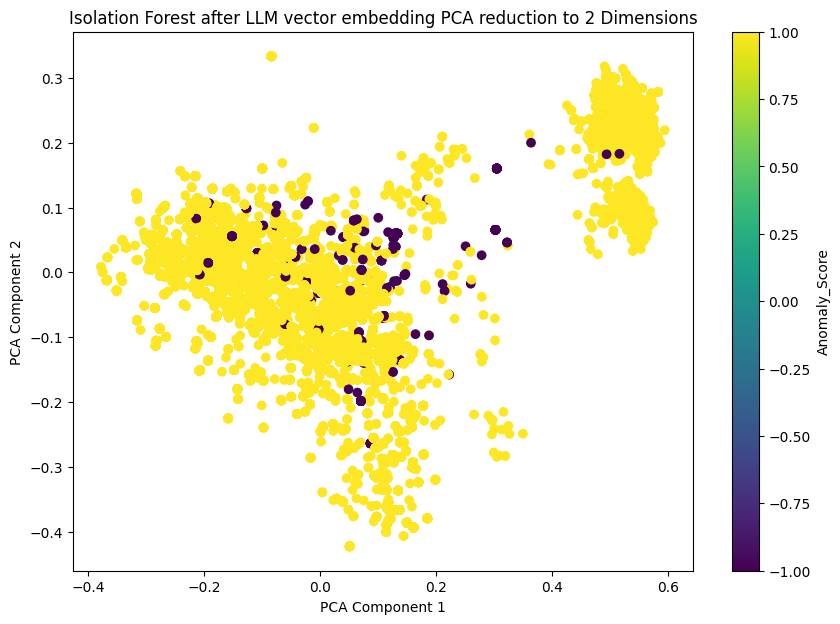

In [10]:
# Plot the results after applying PCA to the vector embeddings...color indicates the anomaly score.
# This is a bit like plotting two things to try to understand how/why they align/not...the dark colors are
# the samples that were flagged as anomalies.

# Reduce the 384 dimension vector embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
embeddings = df['embedding'].tolist()
reduced_embeddings = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['anomaly_score'], cmap='viridis', marker='o')
plt.title('Isolation Forest after LLM vector embedding PCA reduction to 2 Dimensions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Anomaly_Score')
plt.show()

# Judging from the plot, this appears to have done a decent job with the anomaly detection



The plot from the isolation forest model built from LLM embeddings looks a little less segregated than I would have expected.  We of course need to dig into why these records were flagged as anomalies. 

In [11]:
df[df['anomaly_score'] == -1].sample(5)

,protocol,resolved_address,class,query_type,response,rejected,document,embedding,raw_score,anomaly_score
22714,udp,dev.mysql.com,C_INTERNET,A,NXDOMAIN,F,udp dev.mysql.com c_internet a nxdomain f,"[0.012729152, -0.028095761, 0.008774701, -0.07...",-0.012078,-1
1019,udp,version.bind,C_CHAOS,TXT,-,F,udp version.bind c_chaos txt - f,"[0.011498931, 0.054708026, 0.03300669, -0.0478...",-0.070094,-1
24027,udp,-,-,-,NXRRSet,F,udp - - - nxrrset f,"[-0.020034852, 0.021595383, 0.006863743, -0.05...",-0.007698,-1
23942,udp,-,-,-,NXRRSet,F,udp - - - nxrrset f,"[-0.020034852, 0.021595383, 0.006863743, -0.05...",-0.007698,-1
680,udp,version.bind,C_CHAOS,TXT,-,F,udp version.bind c_chaos txt - f,"[0.011498931, 0.054708026, 0.03300669, -0.0478...",-0.070094,-1


In [12]:
df_anomalies = df[df['anomaly_score'] == -1]  # DF w/ anomalies only
df_normal = df[df['anomaly_score'] == 1]  # DF w/ non-anomaly data

In [13]:
# Summary statistics for original features
df_anomalies[['protocol', 'resolved_address', 'class', 'query_type', 'response', 
              'rejected']].describe(include='all')


,protocol,resolved_address,class,query_type,response,rejected
count,432,432,432,432,432,432
unique,2,71,4,8,7,2
top,udp,version.bind,C_INTERNET,A,-,F
freq,371,58,288,181,270,416


In [14]:
# Most common values within each feature
for column in ['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']:
    print(f"FEATURE: {column}")
    print(df_anomalies[column].value_counts())
    print("\n")


FEATURE: protocol
protocol
udp    371
tcp     61
Name: count, dtype: int64


FEATURE: resolved_address
resolved_address
version.bind                                58
www.bestpractical.com                       55
-                                           39
autodiscover.west.exch028.serverdata.net    31
www.hulu.com                                28
                                            ..
ubuntu-2.local                               1
jqueryui.com                                 1
www.backtrack-linux.org                      1
secure.informaction.com                      1
creativecommons.org                          1
Name: count, Length: 71, dtype: int64


FEATURE: class
class
C_INTERNET      288
C_CHAOS          69
-                39
qclass-32769     36
Name: count, dtype: int64


FEATURE: query_type
query_type
A        181
TXT       73
PTR       51
AAAA      43
-         39
AXFR      32
*         11
HINFO      2
Name: count, dtype: int64


FEATURE: response
response
-   

In [15]:
# Compare feature distributions
for column in ['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']:
    print(f"Comparison for feature: {column}")
    print("ANOMALIES:")
    print(df_anomalies[column].value_counts())
    print("\nNORMAL:")
    print(df_normal[column].value_counts())
    print("\n")


Comparison for feature: protocol
ANOMALIES:
protocol
udp    371
tcp     61
Name: count, dtype: int64

NORMAL:
protocol
udp    27503
Name: count, dtype: int64


Comparison for feature: resolved_address
ANOMALIES:
resolved_address
version.bind                                58
www.bestpractical.com                       55
-                                           39
autodiscover.west.exch028.serverdata.net    31
www.hulu.com                                28
                                            ..
ubuntu-2.local                               1
jqueryui.com                                 1
www.backtrack-linux.org                      1
secure.informaction.com                      1
creativecommons.org                          1
Name: count, Length: 71, dtype: int64

NORMAL:
resolved_address
teredo.ipv6.microsoft.com                    2601
tools.google.com                              912
www.apple.com                                 878
time.apple.com                          

The data in column 'resolved_address' seems to be the primary driver for classification as an anomaly, but combinations might also be a notable factor.  Let's dig a little deeper into examining the possible reasons for being flagged as an anomaly.

In [16]:
# Suppress certain warnings
# Suppress SettingWithCopyWarning globally within pandas
pd.set_option('mode.chained_assignment', None)


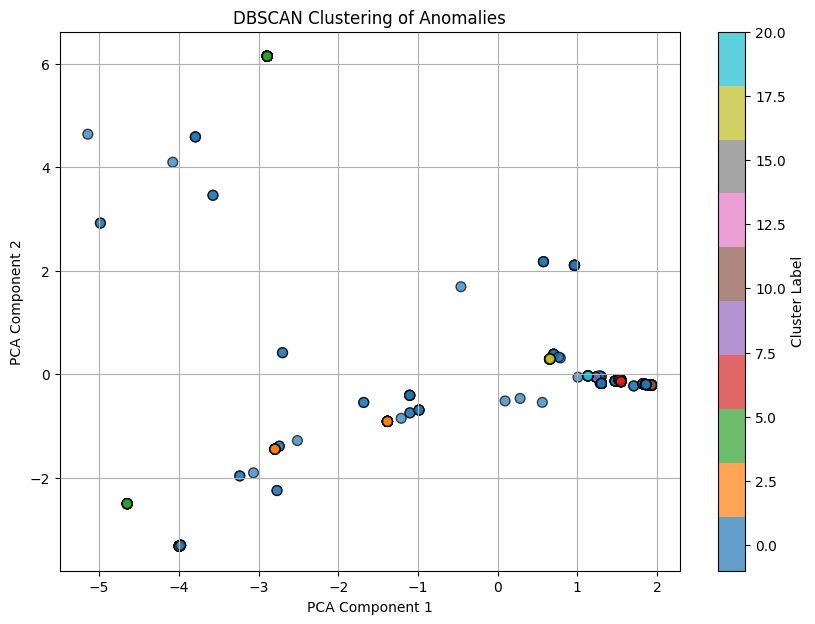

Number of clusters found by DBSCAN: 21
CLUSTER SIZES:
cluster
-1     111
 11     55
 16     31
 5      30
 2      27
 1      20
 17     17
 0      17
 4      15
 3      12
 7      11
 14     10
 18     10
 12     10
 15      8
 20      8
 6       8
 8       7
 10      7
 13      6
 9       6
 19      6
Name: count, dtype: int64

CLUSTER 0 ANALYSIS:
     protocol resolved_address       class query_type response rejected
26        udp     www.hulu.com  C_INTERNET          A        -        F
1751      udp     www.hulu.com  C_INTERNET          A        -        F
1752      udp     www.hulu.com  C_INTERNET          A        -        F
4138      udp     www.hulu.com  C_INTERNET          A        -        F
4139      udp     www.hulu.com  C_INTERNET          A        -        F

CLUSTER 1 ANALYSIS:
     protocol       resolved_address       class query_type response rejected
438       udp  _sane-port._tcp.local  C_INTERNET        PTR        -        F
769       udp  _sane-port._tcp.local  C_

In [17]:
# Let's try DBSCAN clustering of the original features for the anomalies only
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Select the 6 original features
features = ['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']

# Step 1: One-Hot Encode Categorical Features
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_anomalies[features])

# Step 2: Standardize the Encoded Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(encoded_features)

# Step 3: Perform DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Adjust `eps` and `min_samples` as needed
dbscan_labels = dbscan.fit_predict(scaled_features)

# Add cluster labels to the anomalies dataframe
df_anomalies['cluster'] = dbscan_labels

# Step 4: Visualize with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create a scatter plot of the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pca_result[:, 0], 
    pca_result[:, 1], 
    c=dbscan_labels, 
    cmap='tab10', 
    s=50, 
    alpha=0.7, 
    edgecolors='k'
)
plt.colorbar(scatter, label='Cluster Label')
plt.title('DBSCAN Clustering of Anomalies')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

# Step 5: Print Number of Clusters
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters found by DBSCAN: {n_clusters}")

# Print the size of each cluster
cluster_sizes = df_anomalies['cluster'].value_counts()
print("CLUSTER SIZES:")
print(cluster_sizes)

# Step 5: Optional - Analyze Common Patterns in Each Cluster
for cluster_id in range(6):
    print(f"\nCLUSTER {cluster_id} ANALYSIS:")
    print(df_anomalies[df_anomalies['cluster'] == cluster_id][['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']].head())



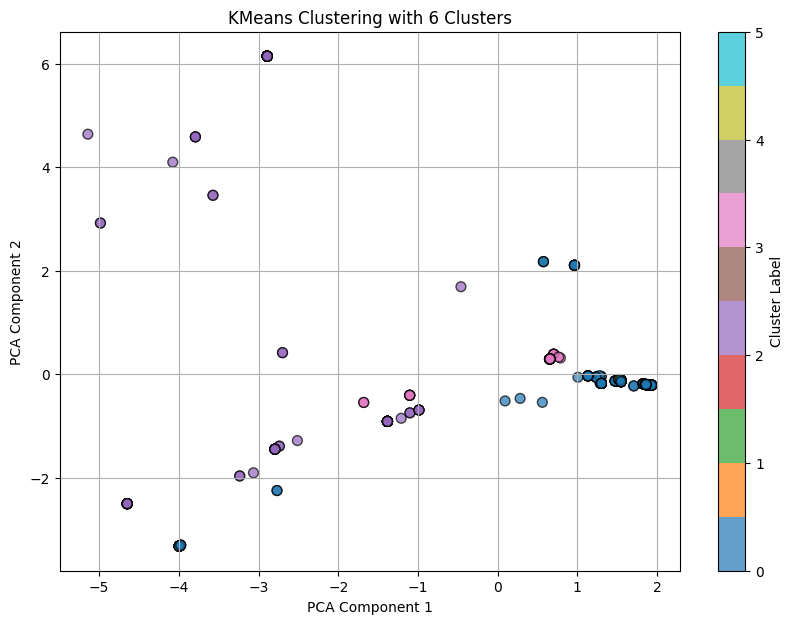

CLUSTER SIZES:
cluster_kmeans
0    273
2    109
3     36
4      7
5      6
1      1
Name: count, dtype: int64

CLUSTER 0 ANALYSIS:
    protocol                resolved_address       class query_type  response  \
14       udp          _xmppconnect.gmail.com  C_INTERNET        TXT  NXDOMAIN   
26       udp                    www.hulu.com  C_INTERNET          A         -   
97       udp         _sleep-proxy._udp.local  C_INTERNET        PTR         -   
136      udp             ajax.googleapis.com  C_INTERNET          A  NXDOMAIN   
197      udp  254.229.168.192.list.quorum.to  C_INTERNET          A  NXDOMAIN   

    rejected  
14         F  
26         F  
97         F  
136        F  
197        F  

CLUSTER 1 ANALYSIS:
      protocol  resolved_address       class query_type response rejected
21974      udp  validator.w3.org  C_INTERNET       AAAA  REFUSED        T

CLUSTER 2 ANALYSIS:
    protocol resolved_address    class query_type response rejected
588      udp     version.bind  C_C

In [18]:
# Let's try KMeans clustering with 6 groups (since there are 6 original features) for anomalies only
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Preprocess the data (One-Hot Encoding + Scaling)
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_anomalies[['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(encoded_features)

# Step 2: Apply KMeans with 6 Clusters
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the anomalies dataframe
df_anomalies['cluster_kmeans'] = kmeans_labels

# Step 3: Visualize the Clusters Using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=kmeans_labels,
    cmap='tab10',
    s=50,
    alpha=0.7,
    edgecolors='k'
)
plt.colorbar(scatter, label='Cluster Label')
plt.title('KMeans Clustering with 6 Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

# Step 4: Analyze Clusters
# Print the size of each cluster
cluster_sizes = df_anomalies['cluster_kmeans'].value_counts()
print("CLUSTER SIZES:")
print(cluster_sizes)

# Step 5: Optional - Analyze Common Patterns in Each Cluster
for cluster_id in range(6):
    print(f"\nCLUSTER {cluster_id} ANALYSIS:")
    print(df_anomalies[df_anomalies['cluster_kmeans'] == cluster_id][['protocol', 'resolved_address', 'class', 'query_type', 'response', 'rejected']].head())


The clustering exercises both seem to confirm that while there are multiple features involved in being flagged as an anomaly, the resolved_address is the biggest factor in that.  This is a very believable conclusion.  Let's look a little closer at some of the most anomalous rows (based on the decision_function() value from the Isolation Forest model).

In [19]:
# Show top 5 anomaly rows by largest (most negative) iforest_model.decision_function() raw score
df.sort_values(by='raw_score', ascending=True).head(5)

,protocol,resolved_address,class,query_type,response,rejected,document,embedding,raw_score,anomaly_score
1264,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
17355,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
1251,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
811,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
14427,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1


In [20]:
# Show all rows where the iforest_model.decision_function() raw anomaly score < -0.1
df[df['raw_score'] < -0.1]

,protocol,resolved_address,class,query_type,response,rejected,document,embedding,raw_score,anomaly_score
788,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
811,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
1251,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
1264,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
2392,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
2416,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
2417,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
2530,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
2531,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1
10082,tcp,version.bind,C_CHAOS,TXT,NOERROR,F,tcp version.bind c_chaos txt noerror f,"[-0.012828455, 0.10091448, 0.040240854, -0.039...",-0.10081,-1


I've executed this analysis with this LLM to compare it with a home-grown doc2vec model trained on the full contents of Wikipedia and fine-tuned on DNS data from SecRepo.com that I worked through in a previous series of notebooks.  I expected the LLM to perform much better than the fine-tuned doc2vec model, but that does not appear to be the case...they are appear to be in the same ballpark as far as accuracy of the vector embeddings they return is concerned, at least in the number of anomalies they flagged in this DNS test data. 

Next task to examine:  Fine-tuning the LLM with the same DNS data that I used to fine-tune the doc2vec model. Stay tuned...